# Machine Translation using Transformer Models

## Introduction
In this project, we aim to build a machine translation system that translates English sentences into Portuguese. We will use the transformer model architecture, which is highly effective for natural language processing tasks such as translation.

## Installing Dependencies
First, we need to install the necessary libraries.


In [1]:
# Install required libraries
!pip install tensorflow tensorflow-datasets matplotlib

## Data Loading and Exploration
We will use the TED Talks dataset for this task. Let's start by loading and exploring the dataset.


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load the TED Talks dataset with pt_to_en configuration
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

# Display some examples
for pt, en in train_examples.take(5):
    print(f'Portuguese: {pt.numpy().decode("utf-8")}')
    print(f'English: {en.numpy().decode("utf-8")}')
    print()

Portuguese: e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
English: and when you improve searchability , you actually take away the one advantage of print , which is serendipity .

Portuguese: mas e se estes fatores fossem ativos ?
English: but what if it were active ?

Portuguese: mas eles não tinham a curiosidade de me testar .
English: but they did n't test for curiosity .

Portuguese: e esta rebeldia consciente é a razão pela qual eu , como agnóstica , posso ainda ter fé .
English: and this conscious defiance is why i , as an agnostic , can still have faith .

Portuguese: `` `` '' podem usar tudo sobre a mesa no meu corpo . ''
English: you can use everything on the table on me .



## Data Preprocessing
We will tokenize and encode the text data to prepare it for the transformer model. Additionally, we'll split the data into training and validation sets.

In [3]:
from tensorflow.keras.layers import TextVectorization

# Define the tokenizers
max_vocab_size = 20000
output_sequence_length = 40

# English tokenizer
english_vectorizer = TextVectorization(max_tokens=max_vocab_size, output_sequence_length=output_sequence_length)
english_vectorizer.adapt([en for en, pt in train_examples])

# Portuguese tokenizer
portuguese_vectorizer = TextVectorization(max_tokens=max_vocab_size, output_sequence_length=output_sequence_length)
portuguese_vectorizer.adapt([pt for en, pt in train_examples])

# Tokenize the data
def vectorize_text(en, pt):
    en = english_vectorizer(en)
    pt = portuguese_vectorizer(pt)
    return en, pt

train_ds = train_examples.map(vectorize_text)
val_ds = val_examples.map(vectorize_text)

## Model Building
We will define the transformer model architecture. This includes creating the transformer blocks and the overall model structure.


In [4]:
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout
from tensorflow.keras.models import Model

# Define the Transformer block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    attn_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Define the Transformer model
def build_transformer(vocab_size, seq_length, embed_dim, num_heads, ff_dim, num_layers):
    inputs = Input(shape=(seq_length,))
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    for _ in range(num_layers):
        x = transformer_block(x, head_size=embed_dim, num_heads=num_heads, ff_dim=ff_dim)
    outputs = Dense(vocab_size, activation="softmax")(x)
    return Model(inputs, outputs)

# Model parameters
embed_dim = 256
num_heads = 8
ff_dim = 512
num_layers = 4

# Build the model
model = build_transformer(vocab_size=max_vocab_size, seq_length=output_sequence_length,
                          embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, num_layers=num_layers)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 40)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 40, 256)           │       5,120,000 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 40, 256)           │       2,103,552 │ embedding[0][0],           │
│ (MultiHeadAttention)          │                           │                 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 40, 256)           │               0 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 40, 256)           │               0 │ embedding[0][0],           │
│                               │                           │                 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 40, 256)           │             512 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 40, 512)           │         131,584 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 40, 256)           │         131,328 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 40, 256)           │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 40, 256)           │               0 │ layer_normalization[0][0], │
│                               │                           │                 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 40, 256)           │             512 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 40, 256)           │       2,103,552 │ layer_normalization_1[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 40, 256)           │               0 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 40, 256)           │               0 │ layer_normalization_1[0][… │
│                               │                           │               

 Total params: 19,729,952 (75.26 MB)

 Trainable params: 19,729,952 (75.26 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training
We will now train the model using the prepared dataset and display the training and validation metrics.

In [5]:
batch_size = 32
epochs = 5

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 1125s 689ms/step - accuracy: 0.6183 - loss: 3.4246 - val_accuracy: 0.6473 - val_loss: 2.9552
Epoch 2/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 1134s 700ms/step - accuracy: 0.6215 - loss: 3.1804 - val_accuracy: 0.6473 - val_loss: 2.9588
Epoch 3/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 1101s 680ms/step - accuracy: 0.6215 - loss: 3.1703 - val_accuracy: 0.6473 - val_loss: 2.9597
Epoch 4/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 1097s 677ms/step - accuracy: 0.6215 - loss: 3.1664 - val_accuracy: 0.6473 - val_loss: 2.9584
Epoch 5/5
1619/1619 ━━━━━━━━━━━━━━━━━━━━ 1169s 722ms/step - accuracy: 0.6215 - loss: 3.1611 - val_accuracy: 0.6473 - val_loss: 2.9594


## Model Evaluation
Let's evaluate the model's performance on the validation set and visualize the results.

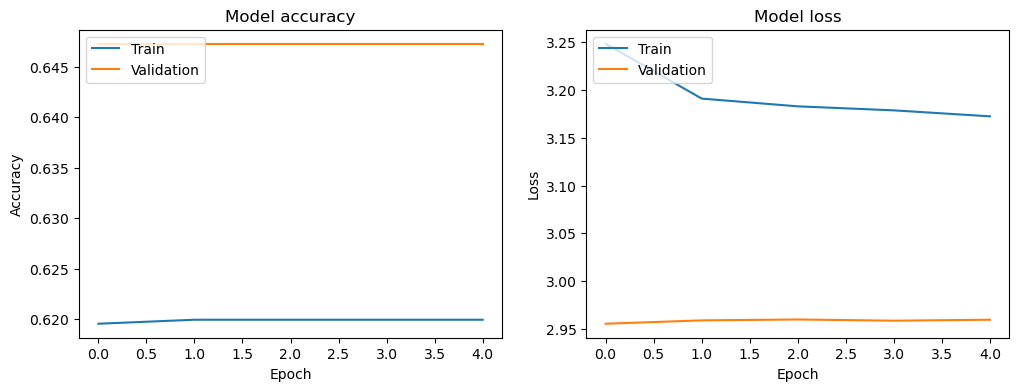

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Translation Function
We will implement a function to translate new sentences from English to Portuguese and test it with sample inputs.

In [9]:
def translate_sentence(sentence, model, vectorizer, target_vectorizer):
    sentence = tf.constant([sentence])
    sentence = vectorizer(sentence)
    predictions = model(sentence)
    predictions = tf.argmax(predictions, axis=-1)
    translated_sentence = " ".join([target_vectorizer.get_vocabulary()[idx] for idx in predictions[0].numpy()])
    return translated_sentence

# Example translation
english_sentence = "How are you?"
translated_sentence = translate_sentence(english_sentence, model, english_vectorizer, portuguese_vectorizer)
print(f"Translated Sentence: {translated_sentence}")

Translated Sentence:                                        
